# SiMFS-Tk Example: Immobilized fluorophore

This example demonstrates the usage of ``simfs_ph2`` in a standalone setting. No diffusion, no excitation focus shape - just a constant laser excitation and a fluorescence rate system.

### Components

- ``simfs_ph2``

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

from pysimfs import *

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


## Looking at ``simfs_ph2`` parameters
Let's take a look at the default parameters of ``simfs_ph2``: Although they look complex, there are only three top-level parameters: An initial state, a Jablonsky diagram and a seed. The Jablonsky diagram specifies the rate system that is simulated. The names of the edges are user defined. Each entry is an edge in the rate graph. Each edge has an source and a target state (``from`` and ``to``) that are also identified by user-defined names. Furthermore, the ``rate`` field specifies the transition rate of this state transition in Hz. This is a standard 3-level system with **S0**, **S1** and **T1** and the common transitions. In addition there is a bleaching transition from **T1** to node **X**. This transition allows the simulation to terminate. Since X is is a dead end, the simulation terminates once this edge is traversed. To produce some output, the emission edge has the ``output`` parameter set to a file, where photon emission event times will be written.

In [2]:
# %simfs_default ph2
ph2_params = {
    'initial_state': 'S0',
    'jablonsky': {
        'bleach': {
            'from': 'T1',
            'rate': 100.0,
            'to': 'X'
        },
        'emi': {
            'from': 'S1',
            'output': 'emi.dat',
            'rate': 100000000.0,
            'to': 'S0'
        },
        'exi': {
            'from': 'S0',
            'rate': 10000000.0,
            'to': 'S1'
        },
        'isc': {
            'from': 'S1',
            'rate': 100000.0,
            'to': 'T1'
        },
        'risc': {
            'from': 'T1',
            'rate': 100000.0,
            'to': 'S0'
        }
    },
    'seed': 2594756866
}

In [3]:
with Simulation() as S:
    S.add(Fluorophore(**ph2_params))
    log = S.run()
    res = S.get_results()

Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 0.3 seconds.


### Inspecting the data

Pysimfs loads the generated data from the simulation files as ``numpy`` arrays with a preset data type.
Photons are plain double precision floating point times.

In [4]:
emission = res['emi.dat']
emission

array([2.98562128e-08, 6.29902782e-08, 8.23357057e-08, ...,
       9.64415140e-02, 9.64416716e-02, 9.64416806e-02])

We see that the simulation terminated after a short time indicating bleaching of the dye. Plotting a histogram of the phtons shows a corresponding bleaching curve:

In [5]:
tmax_pts = int(round(emission.max()*10000*1.2))
tmax = tmax_pts/10000

t = np.linspace(0, tmax, tmax_pts)
hist, bins = np.histogram(emission, bins=t)

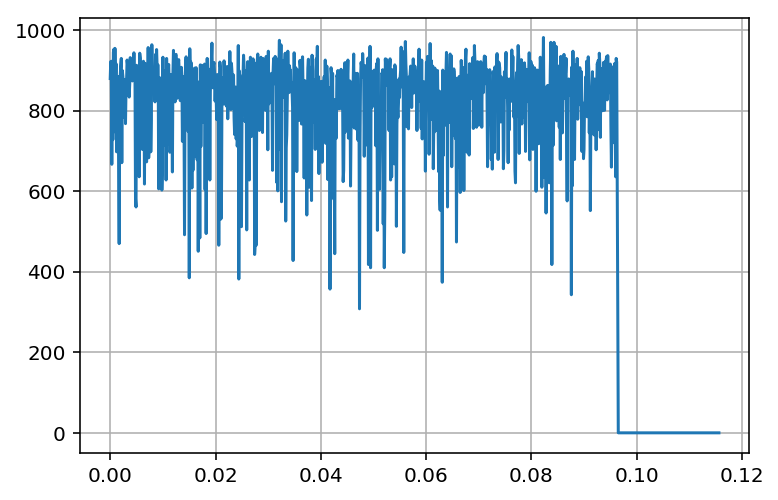

In [6]:
fig = plt.figure()
plt.plot(bins[:-1], hist)
plt.grid()

## Correlation

We can look further into the data with a quick correlation. We are going to use [``pycorrelate``](https://pypi.org/project/pycorrelate/) to do so:

In [7]:
from pycorrelate import pcorrelate

In [8]:
tau = np.logspace(-10, -3, 50)
cor = pcorrelate(emission, emission, tau, normalize=True)

The plot of the correlation reveals the antibunching of photons on the ns timescale as well as the triplet dynamics in the µs regime:

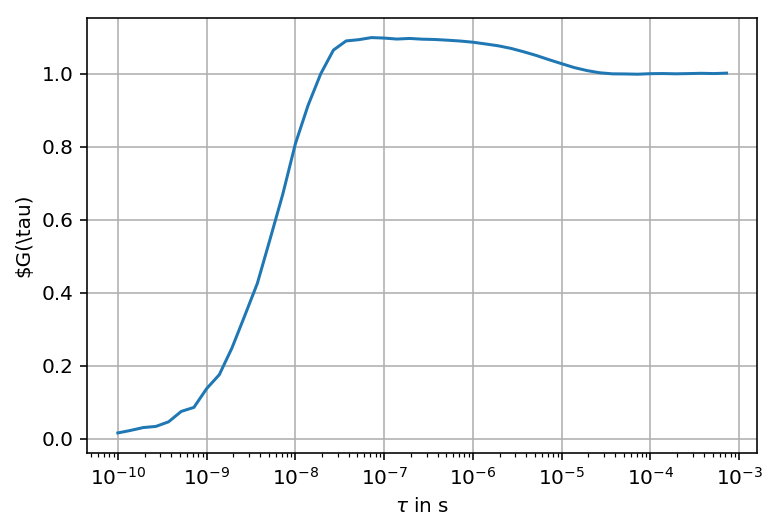

In [9]:
plt.semilogx(tau[:-1], cor)
plt.grid()
_ = plt.xlabel(r'$\tau$ in s')
_ = plt.ylabel(r'$G(\tau)')